In [1]:
import os, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             classification_report, confusion_matrix, roc_curve)
import matplotlib.pyplot as plt

from data_processor import load_features_and_split3, class_weight_hint  
import shap
# Repro
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data
X_train, X_val, X_test, y_train, y_val, y_test = load_features_and_split3(
    "orbit_results_sobol_4.csv", test_size=0.20, val_size=0.10, random_state=SEED, stratify=True
)
feat_names = list(X_train.columns)

# Scale features for MLP
scaler = StandardScaler().fit(X_train.values)
Xtr = scaler.transform(X_train.values)
Xva = scaler.transform(X_val.values)
Xte = scaler.transform(X_test.values)

ytr = y_train.values.astype(np.float32)
yva = y_val.values.astype(np.float32)
yte = y_test.values.astype(np.float32)

# Dataloaders
BATCH = 256
train_ds = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).float())
val_ds   = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).float())
test_ds  = TensorDataset(torch.from_numpy(Xte).float(), torch.from_numpy(yte).float())

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

# Class imbalance hint -> pos_weight for BCEWithLogits
spw = class_weight_hint(y_train)  # neg/pos
pos_weight = torch.tensor([spw], device=device, dtype=torch.float32)
print("scale_pos_weight ~", spw)


Using device: cuda
scale_pos_weight ~ 5.566604127579738


In [2]:
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden=(64, 64), dropout=0.1):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]  # logits
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)  # logits


In [3]:
in_dim = Xtr.shape[1]
model = MLP(in_dim, hidden=(128, 64), dropout=0.1).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # logloss with class weight
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS = 200
PATIENCE = 25

def run_epoch(loader, train: bool):
    model.train(mode=train)
    total_loss, n = 0.0, 0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            bs = yb.size(0)
            total_loss += loss.item() * bs
            n += bs
    return total_loss / max(n, 1)

history = {"train_logloss": [], "val_logloss": []}
best_val = float("inf")
best_epoch = -1
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss = run_epoch(train_loader, True)
    va_loss = run_epoch(val_loader, False)
    history["train_logloss"].append(tr_loss)
    history["val_logloss"].append(va_loss)

    if va_loss < best_val - 1e-6:
        best_val = va_loss
        best_epoch = epoch
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # early stopping
    if epoch - best_epoch >= PATIENCE:
        print(f"Early stopping at epoch {epoch} (best={best_epoch}, val_logloss={best_val:.4f})")
        break

# Load best
if best_state is not None:
    model.load_state_dict(best_state)
print(f"Best epoch: {best_epoch}, best val logloss: {best_val:.4f}")


Early stopping at epoch 146 (best=121, val_logloss=0.4850)
Best epoch: 121, best val logloss: 0.4850


Test ROC AUC: 0.9468
Test PR  AUC: 0.6963

Classification report:
               precision    recall  f1-score   support

         0.0      0.987     0.849     0.913      1696
         1.0      0.527     0.938     0.675       304

    accuracy                          0.863      2000
   macro avg      0.757     0.893     0.794      2000
weighted avg      0.917     0.863     0.877      2000



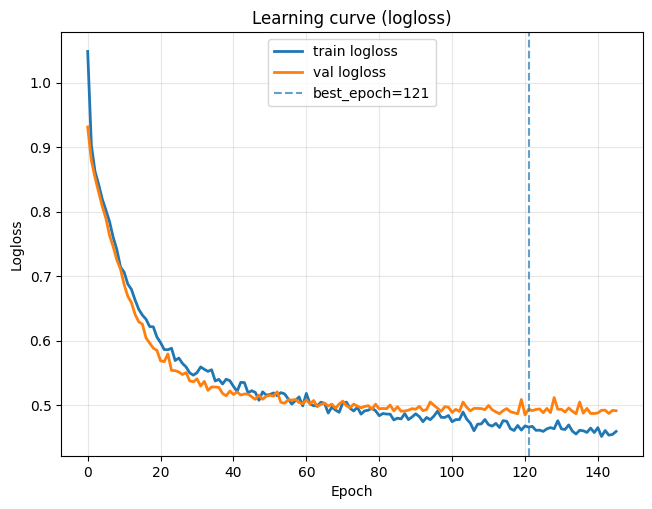

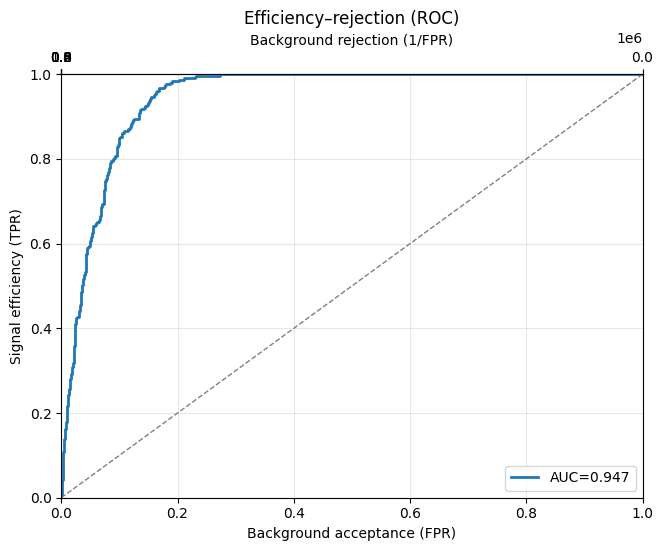

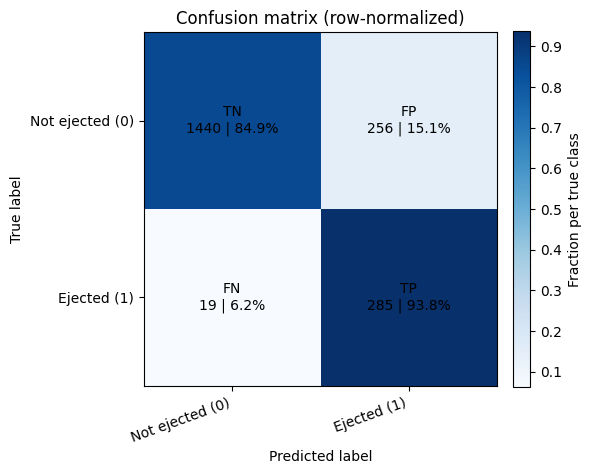

In [4]:
# Predict probabilities on test
model.eval()
proba_list, y_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        proba = torch.sigmoid(logits).cpu().numpy()
        proba_list.append(proba)
        y_list.append(yb.numpy())
proba = np.concatenate(proba_list)
y_true = np.concatenate(y_list)
pred = (proba >= 0.5).astype(int)

# Scalars
print(f"Test ROC AUC: {roc_auc_score(y_true, proba):.4f}")
print(f"Test PR  AUC: {average_precision_score(y_true, proba):.4f}")
print("\nClassification report:\n", classification_report(y_true, pred, digits=3))

# A) Learning curve (logloss)
plt.figure(figsize=(7.5,5.5))
plt.plot(history["train_logloss"], label="train logloss", lw=2)
plt.plot(history["val_logloss"],   label="val logloss",   lw=2)
plt.axvline(best_epoch, ls="--", alpha=0.7, label=f"best_epoch={best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Logloss")
plt.title("Learning curve (logloss)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# B) ROC with background rejection top axis
fpr, tpr, _ = roc_curve(y_true, proba)
fig, ax = plt.subplots(figsize=(7.5,5.5))
ax.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc_score(y_true, proba):.3f}")
ax.plot([0,1], [0,1], ls="--", lw=1, color="gray")
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel("Background acceptance (FPR)")
ax.set_ylabel("Signal efficiency (TPR)")
ax.set_title("Efficiency–rejection (ROC)")
def fwd(f): f = np.clip(np.array(f), 1e-6, 1.0); return 1.0/f
def inv(r): r = np.clip(np.array(r), 1.0, 1e6);  return 1.0/r
secax = ax.secondary_xaxis('top', functions=(fwd, inv))
secax.set_xlabel("Background rejection (1/FPR)")
ax.grid(True, alpha=0.3); ax.legend(); plt.show()

# C) Pretty confusion matrix
cm  = confusion_matrix(y_true, pred)
cmn = cm / cm.sum(axis=1, keepdims=True)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
classes = ["Not ejected (0)", "Ejected (1)"]

fig, ax = plt.subplots(figsize=(6,5.5))
im = ax.imshow(cmn, cmap="Blues")
ax.set_title("Confusion matrix (row-normalized)")
ax.set_xticks([0,1], labels=classes, rotation=20, ha="right")
ax.set_yticks([0,1], labels=classes)
for (i, j), v in np.ndenumerate(cmn):
    ax.text(j, i, f"{labels[i,j]}\n{cm[i,j]} | {v*100:.1f}%", ha="center", va="center", fontsize=10)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Fraction per true class")
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
plt.tight_layout(); plt.show()


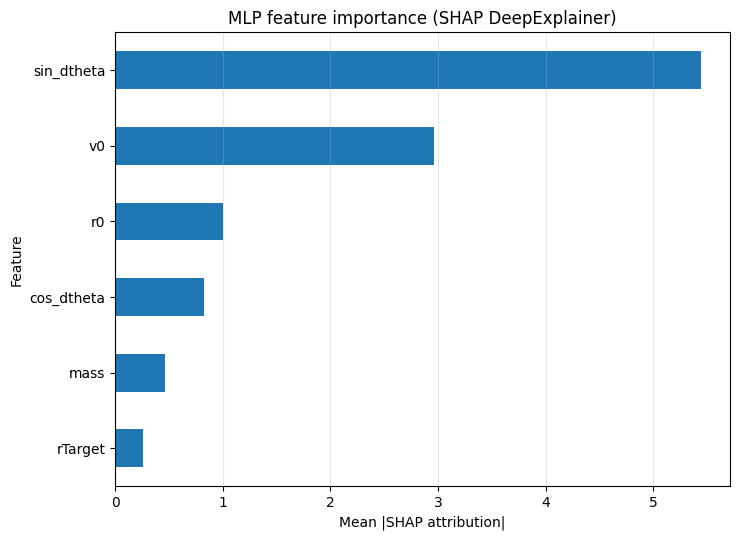

,importance
sin_dtheta,5.442937
v0,2.967374
r0,1.001637
cos_dtheta,0.826000
mass,0.457815
rTarget,0.258756


In [5]:
# === SHAP (PyTorch DeepExplainer) with 2D output wrapper ===

# 1) Wrap your trained model to produce (N,1) logits
class Model2D(nn.Module):
    def __init__(self, base: nn.Module):
        super().__init__()
        self.base = base
    def forward(self, x):
        out = self.base(x)             # (N,) from your MLP
        return out.unsqueeze(1) if out.dim() == 1 else out  # (N,1)

shap_model = Model2D(model).to(device).eval()

# 2) Collect standardized inputs from loaders
def stack_loader(loader, limit=None):
    xs, total = [], 0
    for xb, _ in loader:
        arr = xb.cpu().numpy()
        xs.append(arr); total += len(arr)
        if limit is not None and total >= limit: break
    X = np.concatenate(xs, axis=0)
    return X[:limit] if limit else X

X_bg      = stack_loader(train_loader, limit=2048)   # background pool
X_explain = stack_loader(test_loader,  limit=4000)   # points to explain

# (Optional) compress background via k-means for speed
# bg_np = shap.kmeans(X_bg, 128).data
# bg_t  = torch.from_numpy(bg_np).float().to(device)

bg_t  = torch.from_numpy(X_bg).float().to(device)
exp_t = torch.from_numpy(X_explain).float().to(device)

# 3) DeepExplainer on logits
explainer = shap.DeepExplainer(shap_model, bg_t)

# 4) Compute SHAP values and normalize to (N, F)
shap_raw = explainer.shap_values(exp_t)      # list for multi-output; array for single
shap_vals = shap_raw[0] if isinstance(shap_raw, list) else shap_raw
shap_vals = np.asarray(shap_vals, dtype=float)
if shap_vals.ndim == 3 and shap_vals.shape[-1] == 1:  # sometimes (N, F, 1)
    shap_vals = shap_vals[..., 0]
elif shap_vals.ndim != 2:
    raise ValueError(f"Unexpected SHAP shape {shap_vals.shape}; expected (N,F) or (N,F,1)")

# 5) Mean |SHAP| per feature
importances = np.mean(np.abs(shap_vals), axis=0).ravel()
if len(feat_names) != importances.shape[0]:
    raise ValueError(f"feat_names ({len(feat_names)}) != SHAP dims ({importances.shape[0]})")

imp_series = pd.Series(importances, index=list(feat_names), dtype=float).sort_values(ascending=True)

# 6) Plot like BDT gain bars
plt.figure(figsize=(7.5, 5.5))
imp_series.tail(15).plot(kind="barh")
plt.xlabel("Mean |SHAP attribution|")
plt.ylabel("Feature")
plt.title("MLP feature importance (SHAP DeepExplainer)")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

display(imp_series.sort_values(ascending=False).to_frame("importance").head(20))


In [6]:
os.makedirs("artifacts", exist_ok=True)

# Save model
torch.save(model.state_dict(), "artifacts/mlp_state.pt")

# Save scaler
import joblib
joblib.dump(scaler, "artifacts/mlp_scaler.joblib")

# Save metadata for consistent reload
mlp_meta = {
    "framework": "pytorch",
    "model_file": "mlp_state.pt",
    "scaler_file": "mlp_scaler.joblib",
    "feature_names": feat_names,
    "hidden": [128, 64],
    "dropout": 0.1,
    "best_epoch": int(best_epoch),
    "threshold": 0.5,
    "seed": SEED,
    "pos_weight": float(spw),
}
with open("artifacts/mlp_meta.json", "w") as f:
    json.dump(mlp_meta, f, indent=2)

print("Saved artifacts/mlp_state.pt, mlp_scaler.joblib, mlp_meta.json")


Saved artifacts/mlp_state.pt, mlp_scaler.joblib, mlp_meta.json
